In [56]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import os
from numpy import linalg as LA
from utils import cano_corr, shuffle_block, permutation_test, convolution_mtx, split, leave_one_fold_out
from scipy import signal
from scipy.linalg import toeplitz
from scipy.stats import zscore, pearsonr

### Data preparation
Using the example data file provided by the author. (https://github.com/dmochow/SRC)


In [57]:
data = scipy.io.loadmat('Matlab_version/sampleData.mat')

In [58]:
fsEEG = int(data['fsEEG'])
fsStim = int(data['fsStim'])
sampleEEG = data['sampleEEG']
sampleFeature = np.squeeze(data['sampleFeature'])

In [59]:
downsampledEEG = signal.resample_poly(sampleEEG, fsStim, fsEEG)
sampleFeature = sampleFeature[:downsampledEEG.shape[0]]
normalized_sampleFeature = zscore(sampleFeature)

### CCA

In [60]:
L_timefilter = fsStim
conv_mtx = convolution_mtx(L_timefilter, normalized_sampleFeature)

In [61]:
corr_coe, p_value, V_A, V_B = cano_corr(downsampledEEG, conv_mtx)

In [62]:
corr_coe

array([0.15555451, 0.07868894, 0.0285153 , 0.02611474, 0.0131076 ,
       0.00543612, 0.00255113])

In [63]:
p_value

array([1.48668512e-43, 3.19967909e-12, 1.16722649e-02, 2.09147944e-02,
       2.46434133e-01, 6.30745366e-01, 8.21530108e-01])

In [70]:
filtered_EEG = downsampledEEG@V_A
filtered_Sti = conv_mtx@V_B

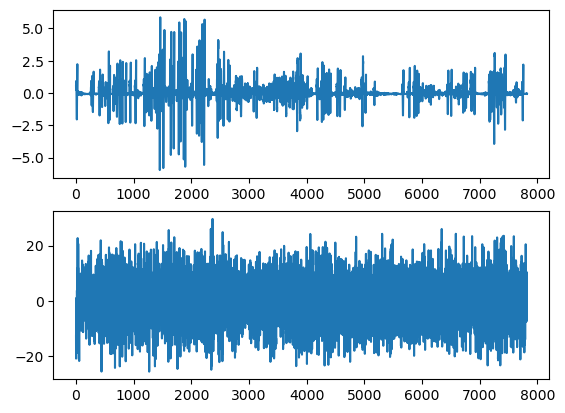

In [76]:
compo = 1
t_axis = range(filtered_Sti.shape[0])
ax1 = plt.subplot(211)
ax1.plot(t_axis, filtered_Sti[:,compo-1])
ax2 = plt.subplot(212, sharex = ax1)
ax2.plot(t_axis, filtered_EEG[:,compo-1])


### Permutation test

In [64]:
num_test = 1000
# Use this then the linear transformations will be generated again based on the permuted data
# The correlation coefficients will not be around zero [because of overfitting?]
# corr_coe_topK = permutation_test(downsampledEEG, normalized_sampleFeature, num_test=num_test, t=1, fs=fsStim, topK=5)

# Use this then V_A and V_B obtained before will be applied to the permuted data directly
# The correlation coefficients will be around zero
corr_coe_topK = permutation_test(downsampledEEG, normalized_sampleFeature, num_test=num_test, t=1, fs=fsStim, topK=5, V_A=V_A, V_B=V_B)

100%|██████████| 1000/1000 [00:05<00:00, 189.48it/s]


Component 2, top 0.0%


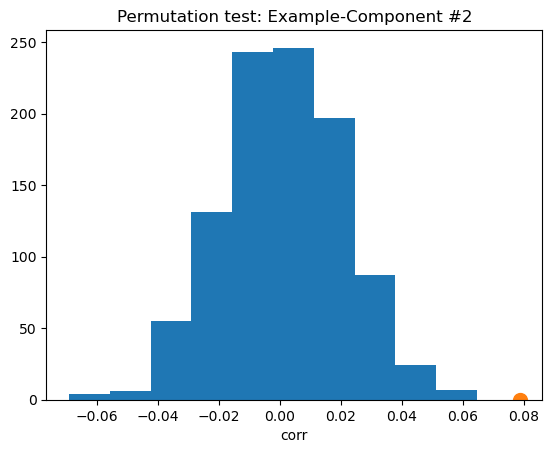

In [65]:
compo = 2
corr_coe_list = corr_coe_topK[:,compo-1]
signifi = sum(corr_coe_topK[:,compo-1]>corr_coe[compo-1])/num_test*100
print("Component {compo}, top {signifi}%".format(compo=compo, signifi=signifi))
plt.hist(corr_coe_topK[:,compo-1])
plt.title('Permutation test: Example-'+'Component #'+str(compo))
plt.xlabel('corr')
plt.plot(corr_coe[compo-1], 0, marker="o", markersize=10)

### Cross-validation

In [66]:
K_regu = 7
fold = 10
fold_idx = 1
corr_coe_train, corr_pvalue = leave_one_fold_out(downsampledEEG, normalized_sampleFeature, L_timefilter, K_regu=K_regu, fold=fold, fold_idx=fold_idx)

In [67]:
corr_coe_train

array([0.15339401, 0.08862426, 0.03366652, 0.02147356, 0.01242458,
       0.00828343, 0.00159724])

In [68]:
corr_pvalue

[(0.1948303380535144, 3.967632337679183e-08),
 (-0.022381517828606968, 0.5319974780891873),
 (-0.07036882573899625, 0.04917128026737254),
 (0.03721149780017788, 0.2986710509344591),
 (0.021417048061249742, 0.5498249127680528),
 (-0.033245608961999434, 0.3531698167198499),
 (0.025713473699093985, 0.4727407470241843)]

In [69]:
corr_coe_avg = np.zeros_like(corr_coe_train)
for idx in range(fold):
    _, corr_pvalue = leave_one_fold_out(downsampledEEG, normalized_sampleFeature, L_timefilter, K_regu=K_regu, fold=fold, fold_idx=idx+1)
    corr_coe_avg = corr_coe_avg + np.array([corr_pvalue[k][0] for k in range(K_regu)])
corr_coe_avg = corr_coe_avg/fold
corr_coe_avg

array([ 0.12286719,  0.00521724, -0.07435749,  0.03349822, -0.00775818,
       -0.00387898,  0.01256763])